In [1]:
%run code/Limpeza.ipynb

In [2]:
%run code/Representacao.ipynb

In [3]:
%run code/Clusterizacao.ipynb

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#-----RDKit-----#
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools, Draw, Descriptors, MACCSkeys, rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.DataStructs import ExplicitBitVect
from rdkit.ML.Cluster import Butina
from rdkit import RDLogger

In [5]:
# Desabilita os warnings do RDKit
RDLogger.DisableLog('rdApp.*')

In [6]:
def canonical_representation(dataframe: pd.DataFrame, col_smiles: str) -> pd.DataFrame:
        # Inicia uma lista vazia para receber os SMILES canônicos
        canonical_smiles = []
        
        # Define a representação canônica de cada registro
        for index in dataframe.index:
            try:
                mol = Chem.MolFromSmiles(dataframe[col_smiles].iloc[index])
                try:
                    Chem.SanitizeMol(mol)  # Sanitiza a molécula
                    mol_sanitize = rdMolStandardize.Cleanup(mol)

                    Uncharger = rdMolStandardize.Uncharger()
                    mol_sanitize = Uncharger.uncharge(mol_sanitize)

                    Tautomer = rdMolStandardize.TautomerEnumerator()
                    tautomero = Tautomer.Canonicalize(mol_sanitize)

                    smile = Chem.MolToSmiles(tautomero, isomericSmiles=False)
                except:
                    smile = np.nan  # Em caso de falha, marca como NaN
            except Exception as e:
                smile = np.nan  # Em caso de falha, marca como NaN
            
            canonical_smiles.append(smile)
            
        # Cria a coluna com SMILES canônicos
        dataframe[col_smiles] = canonical_smiles

        dataframe.dropna(subset=[col_smiles], inplace=True, ignore_index=True)
    
        return dataframe

In [7]:
df = pd.read_csv('data/Acute_Toxicity_mouse_intraperitoneal_LD50.csv', usecols=['Name', 'Canonical SMILES', 'Toxicity Value'])
df.rename(columns={'Name':'name', 'Canonical SMILES':'smiles', 'Toxicity Value':'ld50'}, inplace=True)
df.head()

,name,smiles,ld50
0,hydroquinone,Oc1ccc(O)cc1,99.998184
1,thiotepa,S=P(N1CC1)(N1CC1)N1CC1,10.999767
2,lindane,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,124.986246
3,metformin,CN(C)C(=N)N=C(N)N,294.797771
4,CARVACROL,Cc1ccc(C(C)C)cc1O,73.299512


In [8]:
df.shape

(35299, 3)

In [9]:
df_clean = canonical_representation(df, 'smiles')
df_clean.shape

(35299, 3)

***

## Obtendo os registros repetidos

In [10]:
valores_repetidos = df_clean['smiles'][df_clean['smiles'].duplicated()]
valores_repetidos

1241         O=C(C(O)CO)C(O)C(O)CO
1728     CC(=O)C=CC1=C(C)CCCC1(C)C
7223         NC(C=O)C(O)C(O)C(O)CO
16260         CC(C)=CCC(=O)c1ccoc1
Name: smiles, dtype: object

In [11]:
composto_1 = df_clean[df_clean['smiles'] == valores_repetidos[1241]]
composto_1

,name,smiles,ld50
917,Aldohexose,O=C(C(O)CO)C(O)C(O)CO,18000.39963
1241,NaN,O=C(C(O)CO)C(O)C(O)CO,13600.30197


In [12]:
composto_2 = df_clean[df_clean['smiles'] == valores_repetidos[1728]]
composto_2

,name,smiles,ld50
743,NaN,CC(=O)C=CC1=C(C)CCCC1(C)C,2276.976321
1728,NaN,CC(=O)C=CC1=C(C)CCCC1(C)C,2276.976321


In [13]:
composto_3 = df_clean[df_clean['smiles'] == valores_repetidos[7223]]
composto_3

,name,smiles,ld50
3666,NaN,NC(C=O)C(O)C(O)C(O)CO,2659.970307
7223,NaN,NC(C=O)C(O)C(O)C(O)CO,1599.982140


In [14]:
composto_4 = df_clean[df_clean['smiles'] == valores_repetidos[16260]]
composto_4

,name,smiles,ld50
11981,NaN,CC(C)=CCC(=O)c1ccoc1,9.999756
16260,EGOMAKETONE,CC(C)=CCC(=O)c1ccoc1,9.999756


In [15]:
df = df_clean.drop_duplicates(subset=['smiles'], ignore_index=True)
df.shape

(35295, 3)

***

## Fingerprints

In [16]:
def fp_Morgan(dataframe: pd.DataFrame, col_smiles: str) -> pd.DataFrame:

    PandasTools.AddMoleculeColumnToFrame(frame=dataframe, smilesCol=col_smiles, molCol='molecule')
    
    # Inicia uma lista vazia para receber a representação Morgan
    morgan_lista = []
    
    # Define a representação Morgan de cada registro
    for index in dataframe.index:
        morgan_gen = AllChem.GetMorganGenerator(radius=3, fpSize=4096)

        try:
            morgan = morgan_gen.GetFingerprint(dataframe['molecule'].iloc[index])
        except:
            morgan = np.nan
            
        morgan_lista.append(morgan)

    # Cria a coluna com Morgan fingerprint
    dataframe['fingerprint'] = morgan_lista

    return dataframe

In [17]:
df = fp_Morgan(df, 'smiles')
df.head()

C:\Users\berna\anaconda3\envs\portfolio_ml\Lib\site-packages\rdkit\Chem\PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
C:\Users\berna\AppData\Local\Temp\ipykernel_11920\3267455296.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['fingerprint'] = morgan_lista


,name,smiles,ld50,molecule,fingerprint
0,hydroquinone,Oc1ccc(O)cc1,99.998184,<rdkit.Chem.rdchem.Mol object at 0x0000022BACA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,thiotepa,S=P(N1CC1)(N1CC1)N1CC1,10.999767,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,lindane,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,124.986246,<rdkit.Chem.rdchem.Mol object at 0x0000022BABA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,metformin,CN(C)C(N)=NC(=N)N,294.797771,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CARVACROL,Cc1ccc(C(C)C)cc1O,73.299512,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


***

## Clusterização

In [18]:
def butina_cluster(dataframe: pd.DataFrame, col_fp: str, cutoff: float=0.7) -> pd.DataFrame:

    # Calcula a distância de similaridade
    cutoff = 1 - cutoff
    
    # Obtem os fingerprints (ExplicitBitVect)
    bitVect_array = dataframe[col_fp].to_list()

    # Calcula a distância de similaridade (1 - similaridade)
    matrix_distancia = []
    
    # Comparar todos os pares de fingerprints
    for i in range(len(bitVect_array)):
        for j in range(i):
            # Calcular similaridade de Tanimoto
            similarity = DataStructs.TanimotoSimilarity(bitVect_array[i], bitVect_array[j])
            matrix_distancia.append(1 - similarity)

    # Clusteriza os registros
    clusters = Butina.ClusterData(data=matrix_distancia, nPts=len(bitVect_array), distThresh=cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)

    # Insere na DataFrame o cluster de cada registro
    dataframe['Butina'] = np.nan
    
    for indice in range(len(clusters)):
        # Obtem o índice de cada registro dentro do cluster
        for registro in clusters[indice]:
            dataframe.loc[registro, 'Butina'] = indice

    return dataframe

In [19]:
df = butina_cluster(df, 'fingerprint', .6)
df.head(15)

C:\Users\berna\AppData\Local\Temp\ipykernel_11920\2177259143.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Butina'] = np.nan


,name,smiles,ld50,molecule,fingerprint,Butina
0,hydroquinone,Oc1ccc(O)cc1,99.998184,<rdkit.Chem.rdchem.Mol object at 0x0000022BACA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20310.0
1,thiotepa,S=P(N1CC1)(N1CC1)N1CC1,10.999767,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20309.0
2,lindane,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,124.986246,<rdkit.Chem.rdchem.Mol object at 0x0000022BABA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20308.0
3,metformin,CN(C)C(N)=NC(=N)N,294.797771,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20307.0
4,CARVACROL,Cc1ccc(C(C)C)cc1O,73.299512,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20306.0
5,PAEONOL,COc1ccc(C(C)=O)c(O)c1,780.971801,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20305.0
6,Glucoxy,O=C1OC(C(=O)CO)C(O)C1O,5796.868342,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20304.0
7,Esculetin,O=c1ccc2cc(O)c(O)cc2o1,1499.974738,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20303.0
8,(E/Z)-ferulic acid,COc1cc(C=CC(=O)O)ccc1O,193.994006,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",408.0
9,NaN,C=CC1(C)CCC(C(=C)C)CC1C(=C)C,278.990443,<rdkit.Chem.rdchem.Mol object at 0x0000022BABD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20302.0


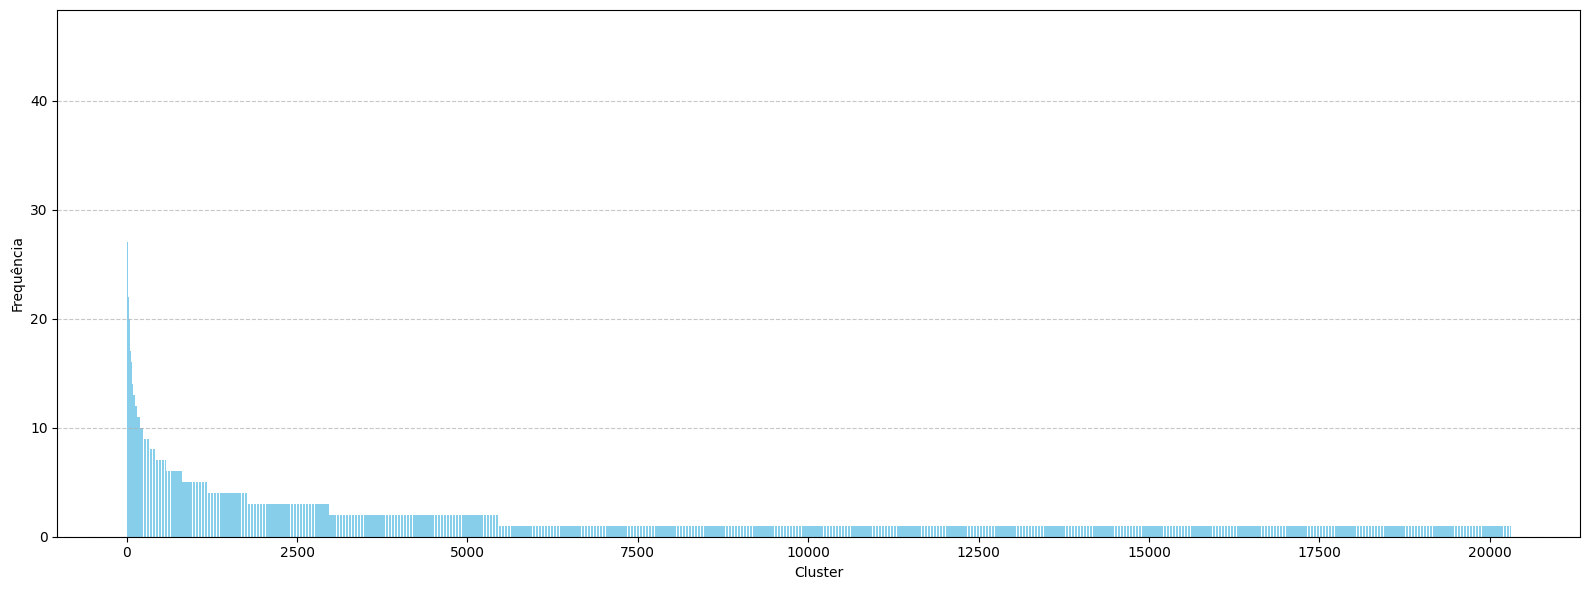

In [72]:
# Contar a frequência de registros em cada cluster
cluster_counts = df['Butina'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(16, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Frequência')
#plt.xticks(cluster_counts.index, rotation=90)  # Rotaciona os rótulos do eixo X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
clusters_nao_singletons = []
for i in cluster_counts.index:
    if cluster_counts[i] > 1:
        clusters_nao_singletons.append(i)

In [22]:
len(clusters_nao_singletons)

5463

C:\Users\berna\AppData\Local\Temp\ipykernel_11920\2434454529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot['log_ld50'] = -np.log(boxplot['ld50'])
C:\Users\berna\AppData\Local\Temp\ipykernel_11920\2434454529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Butina', y='log_ld50', data=boxplot, palette='Set3')


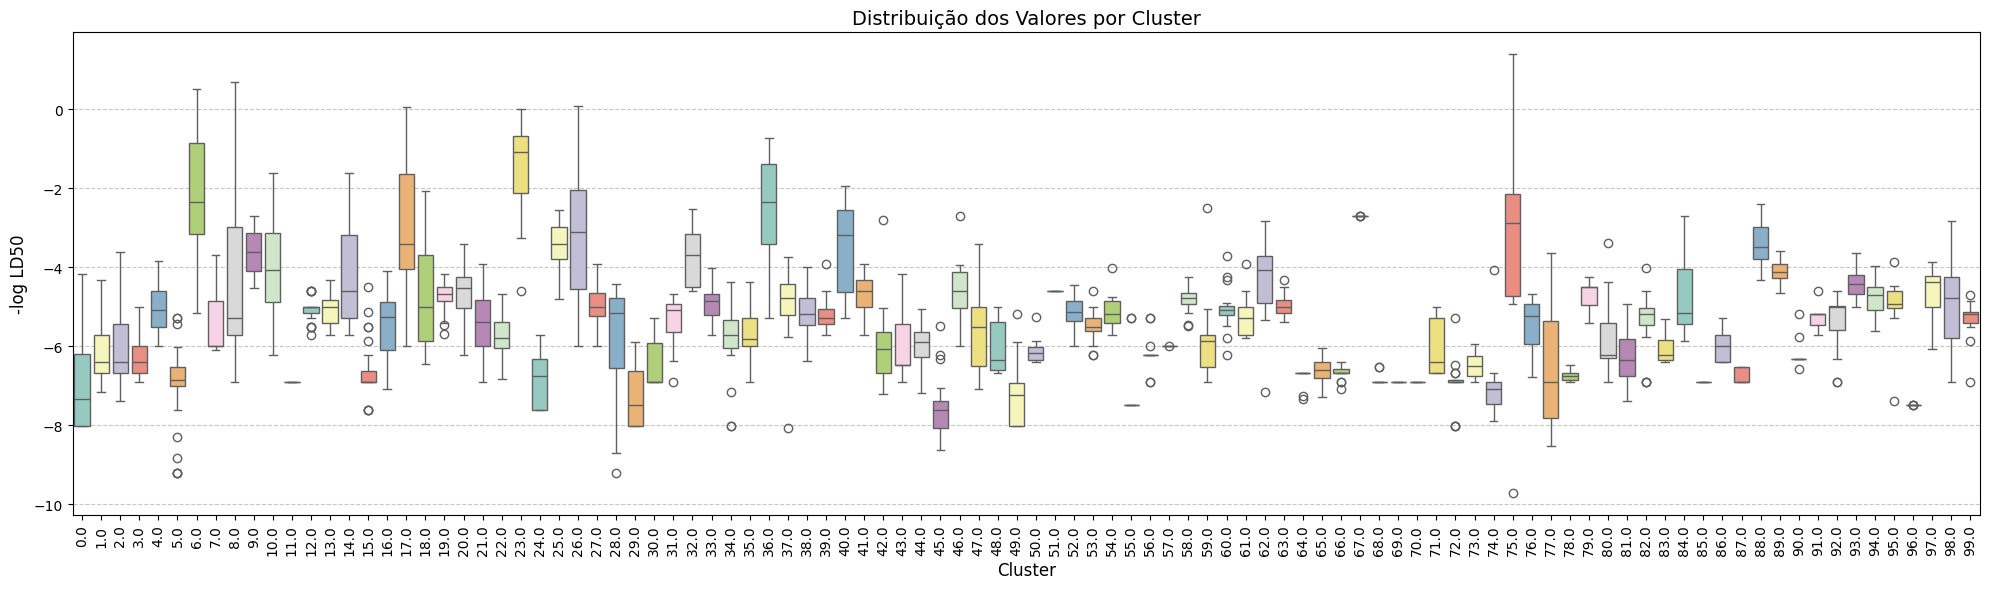

In [32]:
import seaborn as sns

boxplot = df[df['Butina'].isin(clusters_nao_singletons[:100])]
boxplot['log_ld50'] = -np.log(boxplot['ld50'])

# Configurar o tamanho da figura
plt.figure(figsize=(20, 6))

# Criar o boxplot
sns.boxplot(x='Butina', y='log_ld50', data=boxplot, palette='Set3')

# Adicionar títulos e rótulos
plt.title('Distribuição dos Valores por Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('-log LD50', fontsize=12)
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [63]:
cluster_17 = df[df['Butina'] == 17]

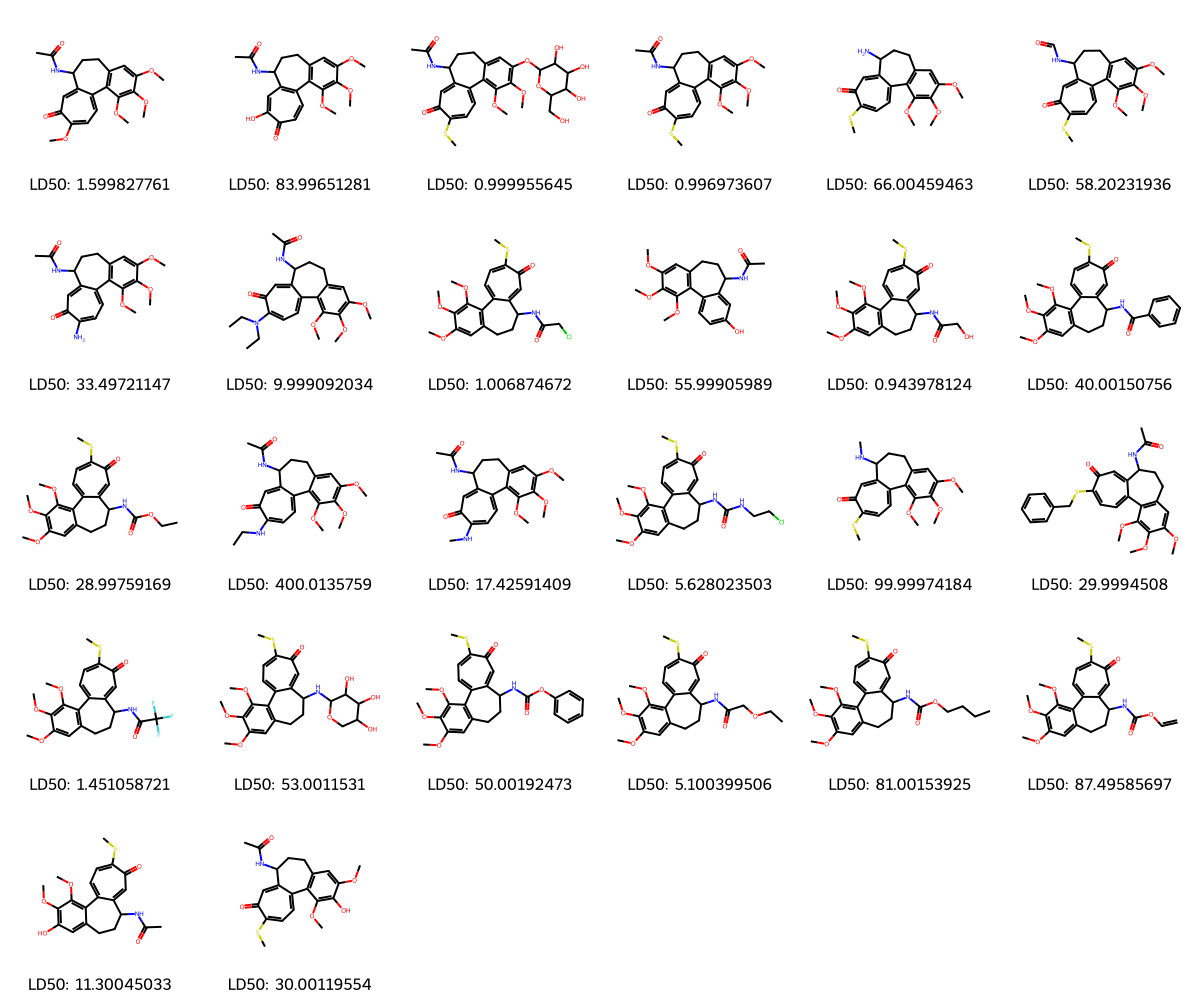

In [64]:
Draw.MolsToGridImage(
    [composto for composto in cluster_17['molecule']],
    legends=[f'LD50: {str(ld50)}' for ld50 in cluster_17['ld50']],
    molsPerRow=6,
)

In [70]:
cluster_11 = df[df['Butina'] == 51]

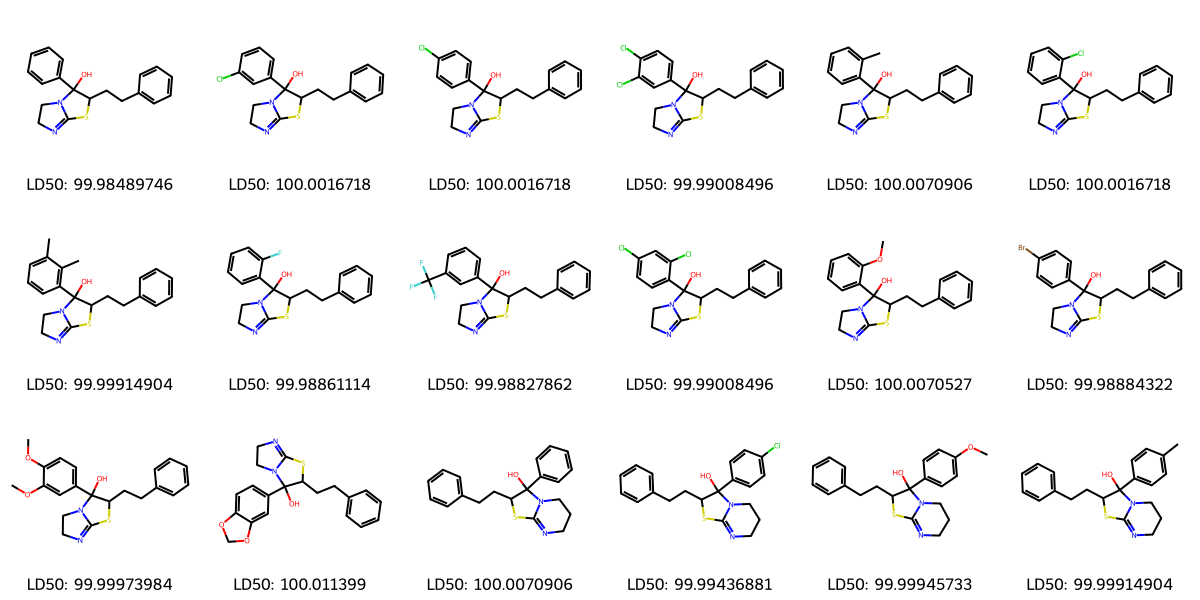

In [71]:
Draw.MolsToGridImage(
    [composto for composto in cluster_11['molecule']],
    legends=[f'LD50: {str(ld50)}' for ld50 in cluster_11['ld50']],
    molsPerRow=6,
)